In [6]:
import warnings
warnings.simplefilter(action='ignore')

import logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

In [7]:
import os
import json
import pandas as pd
import geopandas as gpd
from io import BytesIO
from datetime import datetime
from arcgis.gis import GIS

In [8]:
logging.basicConfig(level=logging.INFO, format='%(message)s')

In [9]:
#locations
wks= r'Q:\dss_workarea\mlabiadh\workspace\20241015_Park_assets_script'
f_assets= os.path.join(wks, 'data', 'PARC_citywide_export.xlsx')

In [10]:
# read the assets xlsx into a df
df= pd.read_excel(f_assets)
df.shape

(103681, 13)

In [11]:
# make GIS-friendly column names
df.columns = df.columns.str.replace(' - ', '_').str.replace(' ', '_')
df.columns

Index(['Asset_ID', 'GIS_ID', 'Park', 'Park_Subarea', 'Category_Classification',
       'Segment_Sub_Classification', 'Description', 'Campsite_Number', 'Name',
       'acs_Is_Asset_Accessible', 'acs_Is_the_Route_to_the_Asset_Accessible',
       'GIS_Latitude', 'GIS_Longitude'],
      dtype='object')

In [12]:
# remove rows with missing coordinates
df = df.dropna(subset=['GIS_Latitude', 'GIS_Longitude'])
df.shape

(103496, 13)

In [13]:
# check for out-of-range coordinates
lat_min, lat_max = 47, 60
lon_min, lon_max = -145, -113

outside_bc = df[
    (df['GIS_Latitude'] < lat_min) | (df['GIS_Latitude'] > lat_max) |
    (df['GIS_Longitude'] < lon_min) | (df['GIS_Longitude'] > lon_max)
]

outside_bc.shape


(0, 13)

In [32]:
# convert to geodataframe
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['GIS_Longitude'], df['GIS_Latitude']),
    crs="EPSG:4326"
)
gdf.shape

(103496, 14)

In [33]:
# convert object cols to strings (objects not supported by fiona)
gdf = gdf.astype(
    {col: 'str' for col in gdf.select_dtypes(include=['object']).columns}
    )
gdf.dtypes

Asset_ID                                       int64
GIS_ID                                        object
Park                                          object
Park_Subarea                                  object
Category_Classification                       object
Segment_Sub_Classification                    object
Description                                   object
Campsite_Number                               object
Name                                          object
acs_Is_Asset_Accessible                       object
acs_Is_the_Route_to_the_Asset_Accessible      object
GIS_Latitude                                 float64
GIS_Longitude                                float64
geometry                                    geometry
dtype: object

In [16]:
#test - export to file
#gdf.to_file(os.path.join(wks, 'work', 'test_assets.geojson'))

In [17]:
# connect to AGOL
def connect_to_AGO (HOST, USERNAME, PASSWORD):
    """ 
    Connects to AGOL
    """     
    gis = GIS(HOST, USERNAME, PASSWORD)

    # Test if the connection is successful
    if gis.users.me:
        logging.info(f'..successfully connected to AGOL as {gis.users.me.username}')
    else:
        logging.error('..connection to AGOL failed.')
    
    return gis


AGO_HOST = os.getenv('AGO_HOST')
AGO_USERNAME = os.getenv('AGO_USERNAME_ML')
AGO_PASSWORD = os.getenv('AGO_PASSWORD_ML')

gis = connect_to_AGO(AGO_HOST, AGO_USERNAME, AGO_PASSWORD)

..successfully connected to AGOL as MLABIADH.BC


In [76]:
def publish_feature_layer(gis, gdf, title, folder):
    """
    Publishes a gdf to AGO as Feature Layer, overwriting if it already exists.
    """

    #format null values
    gdf = gdf.replace(['nan'], '')

    def gdf_to_geojson(gdf):
            features = []
            for _, row in gdf.iterrows():
                feature = {
                    "type": "Feature",
                    "properties": {},
                    "geometry": row['geometry'].__geo_interface__
                }
                for column, value in row.items():
                    if column != 'geometry':
                        if isinstance(value, (datetime, pd.Timestamp)):
                            feature['properties'][column] = value.isoformat() if not pd.isna(value) else ''
                        else:
                            feature['properties'][column] = value
                features.append(feature)
            
            geojson_dict = {
                "type": "FeatureCollection",
                "features": features
            }
            return geojson_dict

    # Convert GeoDataFrame to GeoJSON
    geojson_dict = gdf_to_geojson(gdf)

    try:
        #search for an existing GeoJSON
        existing_items = gis.content.search(
            f"title:\"{title}\" AND owner:{gis.users.me.username}",
            item_type="GeoJson"
        )
        # if an existing GeoJSON is found, Delete it
        for item in existing_items:
            if item.type == 'GeoJson':
                item.delete(force=True, permanent=True)
                logging.info(f"..existing GeoJSON item '{item.title}' deleted.")

        # Create a new GeoJSON item
        geojson_item_properties = {
            'title': title,
            'type': 'GeoJson',
            'tags': 'park assets,geojson',
            'description': 'Point dataset containing Park Assets',
            'fileName': 'assets.geojson'
        }
        geojson_file = BytesIO(json.dumps(geojson_dict).encode('utf-8'))
        new_geojson_item = gis.content.add(item_properties=geojson_item_properties, data=geojson_file, folder=folder)

        # Overwrite the existing feature layer or create a new one if it doesn't exist
        published_item = new_geojson_item.publish(overwrite=True)
        logging.info(f"..feature layer '{title}' published successfully.")

        return published_item


    except Exception as e:
        error_message = f"..error publishing/updating feature layer: {str(e)}"
        raise RuntimeError(error_message)

(100, 14)


..existing GeoJSON item 'PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests' deleted.
..feature layer 'PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests' published successfully.


<Item title:"PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests" type:Feature Layer Collection owner:MLABIADH.BC>
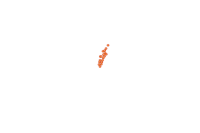

In [81]:
title= 'PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests'
folder= '2024_PARC'

gdf_test = gdf.head(100)
print (gdf_test.shape)

#LayerID: 639540fc1e7c40c5a2954cdc3b4185da

publish_feature_layer(gis, gdf_test, title, folder)